In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Búsqueda dicotómica

También conocido como búsqueda binaria.

In [2]:
def dicotomic_search(f, interval, l=0.005, epsilon=1e-10, verbose=False):
    """
        Implements binary search looking for the min value in
        `f` inside the interval `interval`.
        
        Pre-requisites:
        - f must be estrictly cuasiconvex inside the
            given interval.
        
        Arguments:
        - f -> callable
            Function to be minimized.
        - initial_interval -> numpy.darray
            Interval where to look for the minimum
        - l -> float
            Precision of the search. The returned interval
            will have length smaller than l.
        - epsilon -> float
            The distance taken from the middle element the 
            subinterval cut performed in each step of the
            algorithm.
        
        Returns the index of the first instance of the element.
        If the element is not in the array, returns -1.
    """
    # Initialize indexes
    i_lower, i_upper = interval
    k = 1
    
    # Apply binary search to find the element
    while i_upper - i_lower >= l:
        # Compute middle pivotss
        middle_cut = (i_upper + i_lower) / 2.0
        mc_left = middle_cut - epsilon
        mc_right = middle_cut + epsilon
        
        # Update subarray in study
        if f(mc_left) < f(mc_right):
            i_upper = mc_right
        else:
            i_lower = mc_left
        
        # Update the steps counter
        k += 1
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return (i_lower, i_upper)

In [3]:
def test_search_algorithm(algorithm, f, interval, title=None):
    i_init, i_end = interval[0]-1, interval[1]+1 
    step = 0.0001
    
    x = np.arange(i_init, i_end, step)
    plt.plot(x, f(x), color='deepskyblue')
    
    min_int = algorithm(f, interval, verbose=True)
    plt.axvline(x=min_int[0], color='tomato')
    plt.axvline(x=min_int[1], color='tomato')

    plt.axvline(x=interval[0], color='darkblue')
    plt.axvline(x=interval[1], color='darkblue')
    
    if title is not None:
        plt.title(title)
    
    custom_lines = [Line2D([0], [0], color='deepskyblue', lw=2),
                    Line2D([0], [0], color='tomato', lw=2),
                    Line2D([0], [0], color='darkblue', lw=2)]
    plt.legend(custom_lines, ['f', 'min', 'interval'])


Steps taken: 11


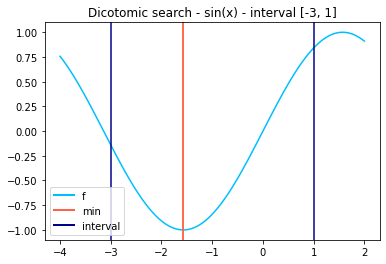

Steps taken: 12


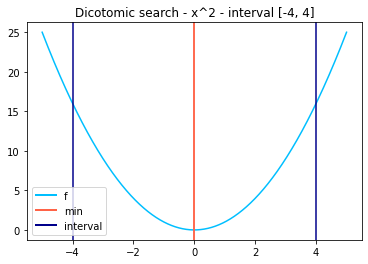

Steps taken: 12


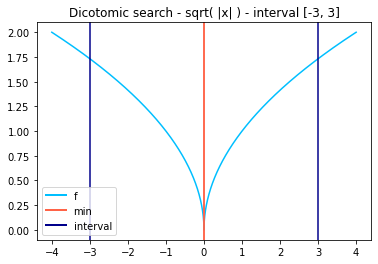

In [4]:
def run_all_tests(algorithm, algorithm_name=''):
    test_cases = [
        (np.sin, [-3, 1], 'sin(x)'),
        (lambda x: x**2, [-4, 4], 'x^2'),
        (lambda x: np.sqrt(np.abs(x)), [-3, 3], 'sqrt( |x| )')
    ]

    for f, interval, f_name in test_cases:
        title = '{} - {} - interval {}'.format(algorithm_name, f_name, interval)
        test_search_algorithm(algorithm, f, interval, title)
        plt.show()

run_all_tests(dicotomic_search, 'Dicotomic search')

## Sección Aurea

In [5]:
def golden_section(f, interval, l=0.005, epsilon=1e-10, verbose=False):
    """
        Implements binary search looking for the min value in
        `f` inside the interval `interval`.
        
        Pre-requisites:
        - f must be estrictly cuasiconvex inside the
            given interval.
        
        Arguments:
        - f -> callable
            Function to be minimized.
        - initial_interval -> numpy.darray
            Interval where to look for the minimum
        - l -> float
            Precision of the search. The returned interval
            will have length smaller than l.
        - epsilon -> float
            The distance taken from the middle element the 
            subinterval cut performed in each step of the
            algorithm.
        
        Returns the index of the first instance of the element.
        If the element is not in the array, returns -1.
    """
    # Initialize indexes
    i_lower, i_upper = interval
    alpha = 0.618
    k = 1
    
    # Compute first middle pivots
    pivot_left = i_lower + (1 - alpha)*(i_upper - i_lower)
    pivot_right = i_lower + alpha*(i_upper - i_lower)
    
    # Eval pivots
    f_left = f(pivot_left)
    f_right = f(pivot_right)
    
    # Apply binary search to find the element
    while i_upper - i_lower >= l:
        # Update subarray in study
        if f_left > f_right:
            i_lower = pivot_left
            pivot_left = pivot_right
            f_left = f_right
            
            pivot_right = i_lower + alpha*(i_upper - i_lower)
            f_right = f(pivot_right) 
        else:
            i_upper = pivot_right
            pivot_right = pivot_left
            f_right = f_left
            
            pivot_left = i_lower + (1 - alpha)*(i_upper - i_lower)
            f_left = f(pivot_left) 
        
        # Update the steps counter
        k += 1
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return (i_lower, i_upper)

Steps taken: 15


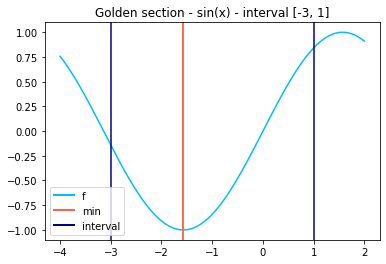

Steps taken: 17


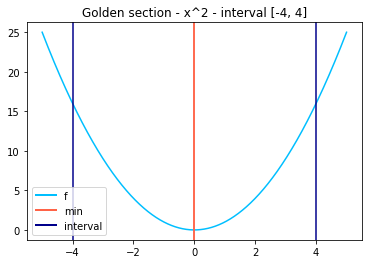

Steps taken: 16


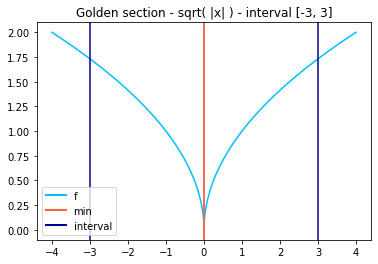

In [6]:
run_all_tests(golden_section, 'Golden section')

## Hooke-Jeeves method



In [73]:
def hooke_jeeves_section(f, start_point,
                         epsilon=1e-5,
                         max_steps=10**6, 
                         one_directional_optimizer=dicotomic_search,
                         interval_radius=5,
                         verbose=False):
    """
        Implements the Hooke-Jeeves method.
        
        Pre-requisites:
        - f must be convex and have a minimum.
        
        Arguments:
        - f -> callable
            2D function to be minimized.
        - start_point -> numpy.darray
            Initial point.
        - epsilon -> float
            Minimum distance between jumps. If the jump
            distance is smaller (|x_ - x_n+1| < eps),
            end the algorithm.
        - one_directional_optimizer -> callable
            Algorithm used to find the minimum in a
            single direction.
        - interval_radius -> float
            Radius of the interval used for one
            directional optimization.
        - max_steps -> int
            Fixes the max number of iterations.
        
        Returns the list of points that the algorithm went through.
        The min of f will be its last position.
    """
    # Initialize variables
    x_n = start_point
    previous_x_n = x_n
    Xs = np.array([x_n])
    k = 1
    d_i = 0
    dimensions = len(x_n)
    interval = (-interval_radius, interval_radius)
    
    while k <= max_steps:
        # Prepare optimization direction
        if d_i != -1:
            direction = np.zeros(dimensions)
            direction[d_i] = 1
        else:
            direction = x_n - previous_x_n
            
        # Prepare optimization function using the direction
        directional_f = lambda x: f(x_n + x*direction)
        
        # Use 1-direction optimization in the computed direction
        found_interval = one_directional_optimizer(directional_f, interval,
                                                   epsilon=epsilon)
        jump_length = (found_interval[0] + found_interval[1]) / 2.0
        x_n = x_n + jump_length*direction
        Xs = np.vstack([Xs, x_n])
        
        # Update the steps counter and the direction index
        k += 1
        d_i = d_i + 1 if d_i + 1 < dimensions else -1
        
        # Update diagonal pivot point if we have gone through
        # all the dimensions
        if d_i == 0:
            previous_x_n = x_n
        
        # Check stop condition
        if np.linalg.norm(x_n - Xs[-2]) < epsilon:
            break
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return Xs

In [75]:
f_2d = lambda x: (x[0] - 2)**4 + (x[0] - 2*x[1])**2

Xs = hooke_jeeves_section(f_2d, start_point=[0,3], interval_radius=3, max_steps=200, verbose=True)

Steps taken: 31


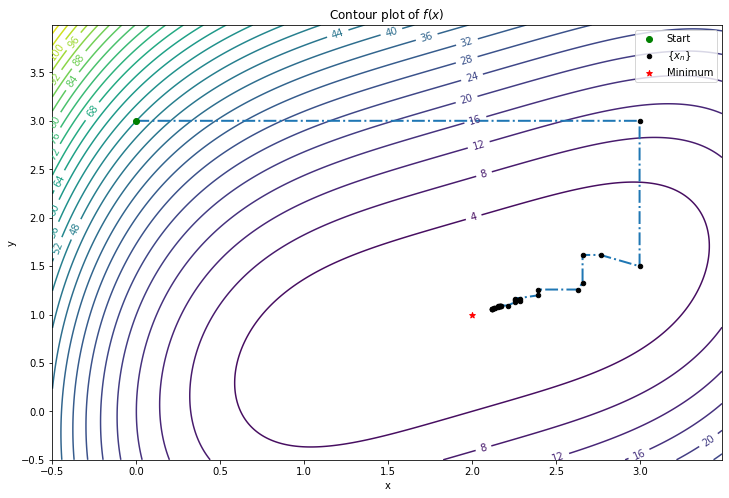

In [76]:
x0, x1 = -0.5, 3.5
y0, y1 = -0.5, 4
x = np.arange(x0, x1, 0.01)
y = np.arange(y0, y1, 0.01)
xx, yy = np.meshgrid(x, y)
z = f_2d([xx, yy])

# Contour plot
plt.figure(figsize=(12,8))
cont = plt.contour(x, y, z, levels=30)
plt.title(r"Contour plot of $f(x)$")
plt.xlabel('x')
plt.ylabel('y')
plt.clabel(cont, inline=True, fontsize=10)
plt.scatter(Xs[0,0], Xs[0,1], color="green", marker="o", label="Start", zorder=20)
plt.scatter(Xs[:, 0], Xs[:, 1], s=20, color='black', zorder=10, label='$\{x_n\}$')
plt.scatter(2, 1, color="red", marker="*", label="Minimum")
plt.plot(Xs[:, 0], Xs[:, 1], "-.", lw=2)
plt.legend()
plt.show()